# Preamble

In [1]:
import numpy as np
import astropy.table as tbl
import os, os.path
import healpy as hp
from astropy.io import ascii
import random
import matplotlib.pyplot as plt
import pymaster as nmt
from kmeans_radec import KMeans, kmeans_sample
import matplotlib
import pickle

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


# Config

In [2]:
#loading in IceCube dataset
ICDir = 'IceCube_dataset3' #directory containing IceCube dataset files
ICEventKW = 'events.txt' #IceCube event files keyword
ICAeffKW = 'TabulatedAeff.txt' #IceCube effective area files keyword

#effective area lookup table
AeffTblZenStepSize = 0.01 #step size of cos(zenith) angle in effective area tables
AeffTblZenRange = 2 #range of cos(zenith) angles in effective area tables
UseAeffWeights = False #whether to use aeff weights (don't work at the moment)

#weighted effective area
PlotWeightedAeff = True #whether to plot weighted effective area maps
ESpectralIndex = 3.7 #assumed energy spectral index of events

#plotting IceCube neutrino maps
NSIDE = 128 #set NSIDE parameter for healpix map
ICDecMin = -5 #neutrino events below this declination are ignored
#ICEMapBands = [(1.5,2.5),(2.5,3.5),(3.5,4.5), #energy bins of neutrino maps
               #(4.5,5.5),(5.5,6.5)]
ICEMapBands = [(2,3),(3,4),(4,5)]
#ICEMapBands = [(4,5)] #list of tuples for custom energy bins

In [3]:
#loading in galaxy maps
GalMapDir = 'Galaxy_Maps' #directory containing galaxy maps (and mask)
GalMapKW = 'map' #galaxy map files keyword
GalMaskKW = 'mask' #galaxy mask file keyword

In [4]:
#NaMaster C_l approximation
LPerBP = 4 #number of l values per bandpower
ApodScale = 1 #scale on which masks are apodized (in degrees)

#Jackknife errors on c_l
ImportJKcls = True #whether to import jackknife cls from disk or calculate from scratch
ImportJKclsPath = 'JKcls' #directory containing jackknife cls
JKRegions = 100 #number of regions to use to calculate jackknife errors
lmin = 75 #minimum l value to use in likelihood calculation

# IceCube Data

## Loading Data

In [5]:
#finds filenames of all IceCube files, sorted alphanumerically
ICAllFilenames = sorted(os.listdir(ICDir))

#selects event data and effective area data IceCube files
ICEventFilenames = []
ICAeffFilenames = []
for i in ICAllFilenames: #only appends files to corresponding lists if keywords contained in filenames
    if ICEventKW in i:
        ICEventFilenames.append(i)
    elif ICAeffKW in i:
        ICAeffFilenames.append(i)


In [6]:
#reads in IceCube effective area data from chosen directory for each year
ICAeffList = []
for i in ICAeffFilenames:
    ICAeffList.append(tbl.Table.read(ICDir + '/' + i, format = 'ascii'))
    
#reads in IceCube neutrino event data from chosen directory for each year
ICEventList = []
for i in range(len(ICEventFilenames)):
    ICEventData = tbl.Table.read(ICDir + '/' + ICEventFilenames[i], format = 'ascii')
    ICEventData['Year'] = np.full(len(ICEventData), i) #add column for year each neutrino event is from
    ICEventList.append(ICEventData)

#combines neutrino event data into a single table
ICEventFull = tbl.vstack(ICEventList)


## Effective Area Lookup

In [43]:
#calculates how many zenith angle rows each table has per fine energy bin
AngsPerFineE = AeffTblZenRange/AeffTblZenStepSize

#finds bounds of fine energy bins for effective area lookup tables

minFineEBounds = ICAeffList[0]['E_min[GeV]'] #assumes all effective area tables formatted in same way

FineEBounds = []
FineEBoundCounter = 0 

for i in minFineEBounds: #loops through table and finds all lower energy bin bounds
    FineEBoundCounter += 1
    if FineEBoundCounter%AngsPerFineE == 0:
        FineEBounds.append(np.log10(i))
        FineEBoundCounter = 0
        
#adds highest max energy bounds, as this is not contained in lower bound search above
MaxFineEBound = np.log10(ICAeffList[0]['E_max[GeV]'][-1]

SyntaxError: unexpected EOF while parsing (3349338749.py, line 18)

In [8]:
#finds effective area of an energy and zenith angle
def AeffLookup(AeffTbl, E, Zen, ZenRange = AeffTblZenRange, 
               ZenStepSize = AeffTblZenStepSize, FineEBounds = FineEBounds):
    #AeffTbl - effective area table to use
    #E - energy to look up (input in log scale)
    #Zen - zenith angle to look up (input in degrees)
    #ZenRange - range of cos(zenith) angles in effective area tables
    #ZenStepSize - step size of cos(zenith) angles in effective area tables
    #FineEBounds - array of the bounds of fine energy bins in effective area tables
    
    #finds which bin number the given energy is in
    if E > FineEBounds[0]:
        for i in range(len(FineEBounds) - 1):
            if E < FineEBounds[i+1]:
                FineEBinNo = i
                break
    else:
        print('Given energy too small for effective area table') #(true for 268 events)
        FoundAeff = 0 #assume effective area in this case to be 0
        return FoundAeff
    
    #finds which bin number the given zenith angle is in
    cosZenAng = np.cos(np.radians(Zen)) + (ZenRange)/2 #assumes symmetric range of cos(zenith angles)
    ZenBinNo = np.floor(cosZenAng/ZenStepSize)
    
    #finds number of rows per fine energy bins in effective area tables
    AngsPerFineE = ZenRange/ZenStepSize
    
    #calculates index of required effective area based on fine energy and zenith angle bin numbers
    AeffIndex = int(FineEBinNo*AngsPerFineE + ZenBinNo)
    FoundAeff = AeffTbl['Aeff[m^2]'][AeffIndex]
    return FoundAeff

/var/folders/8h/rlzy1c754_j6xtylyk0jhy7h000tgx/T/ipykernel_41379/1371146885.py:4: RuntimeWarning: divide by zero encountered in log10
  AeffMoll[i] = np.log10(AeffLookup(ICAeffList[0], 7, (90 + hp.pix2ang(NSIDE, i, lonlat = True)[1])))


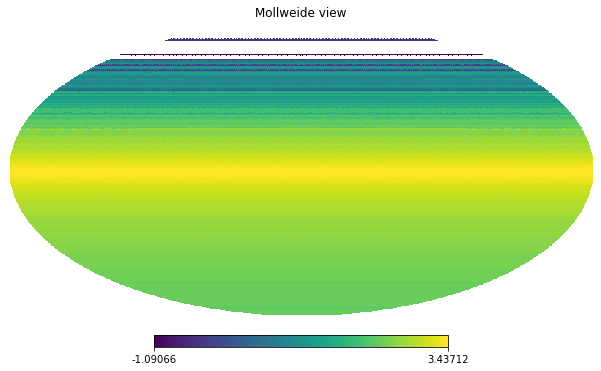

In [9]:
#displays effective area for a given year and energy on a mollweide projection
AeffMoll = np.ones(hp.nside2npix(NSIDE))
for i in range(hp.nside2npix(NSIDE)):
    AeffMoll[i] = np.log10(AeffLookup(ICAeffList[0], 7, (90 + hp.pix2ang(NSIDE, i, lonlat = True)[1])))
hp.mollview(AeffMoll)

## Weighted Effective Area

In [10]:
def WeightedEffArea(AeffTbl, WideELower, WideEUpper, theta, 
                          alpha = ESpectralIndex, FineEBounds = FineEBounds):
    #AeffTbl - effective area table to use
    #WideELower - lower energy band of bin
    #WideEUpper - upper energy band of bin
    #theta - zenith angle(input in degrees)
    #alpha - energy spectral index of events
    #FineEBounds - array of the bounds of fine energy bins in effective area tables
    
    #finds relevant fine energy bins
    UsefulFineEBounds = []
    for i in range(len(FineEBounds)): #finds fine energy bin containing lower wide bound
        if FineEBounds[i] > WideELower:
            UsefulFineEBounds.append(WideELower)
            
            for j in range(len(FineEBounds)):
                if WideEUpper > FineEBounds[j+i]: #adds all energy bins up to upper wide bound
                    UsefulFineEBounds.append(FineEBounds[j+i])
                else:
                    UsefulFineEBounds.append(WideEUpper) #finds fine energy bin containing upper wide bound
                    break
            break
    
    #converts from log scale
    LinFineE = 10**np.array(UsefulFineEBounds)
    WideEL = 10**WideELower
    WideEU = 10**WideEUpper
    
    #variable to return
    WeightedAeff = 0
    
    #sums over each fine bin
    for i in range(len(UsefulFineEBounds) - 1):
        SumAeff = AeffLookup(AeffTbl, (UsefulFineEBounds[i]+UsefulFineEBounds[i+1])/2, theta) #effective area
        SumNum = SumAeff * (LinFineE[i+1]**(1-alpha) - LinFineE[i]**(1-alpha)) #sum numerator
        SumDenom = (WideEU**(1-alpha) - WideEL**(1-alpha)) #sum denominator
        WeightedAeff += (SumNum/SumDenom) #adds this fine bin contribution to sum
        
    #returns weighted efffective area
    return WeightedAeff

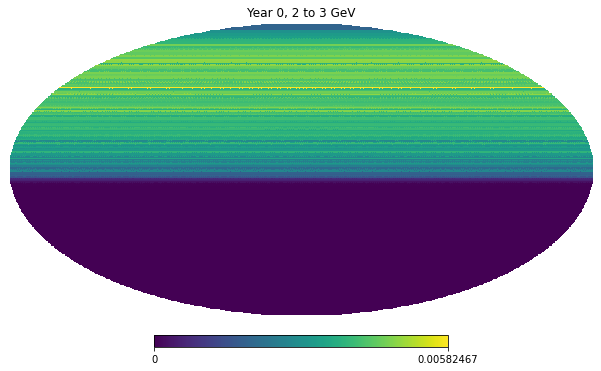

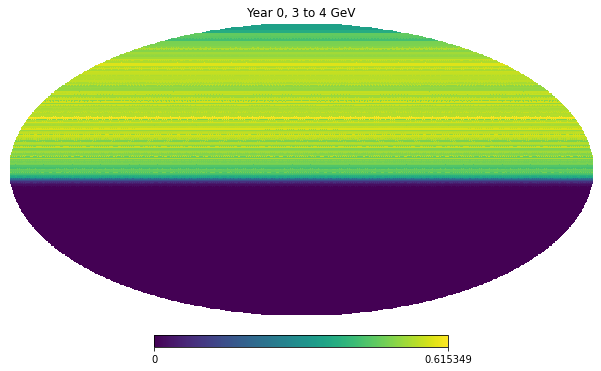

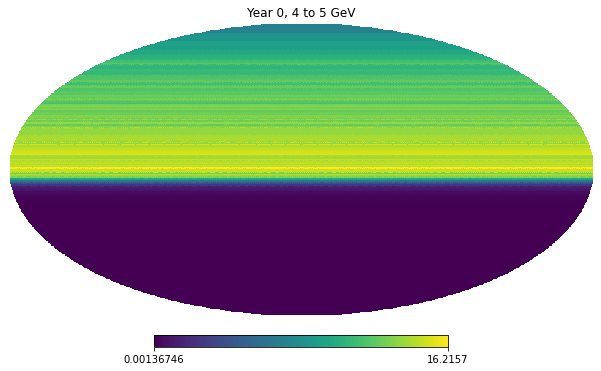

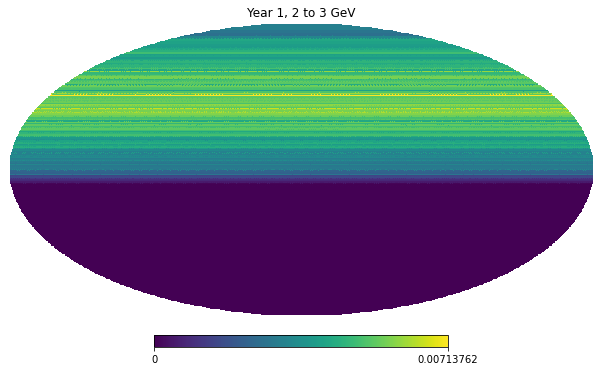

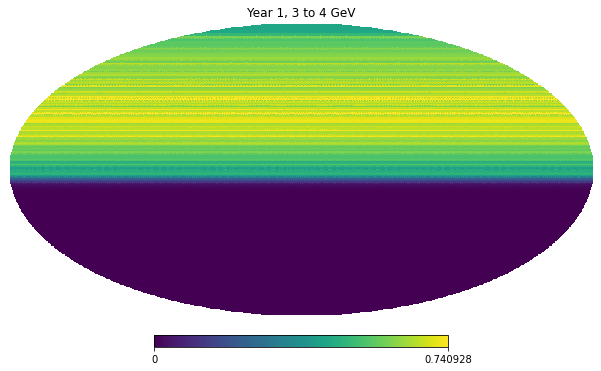

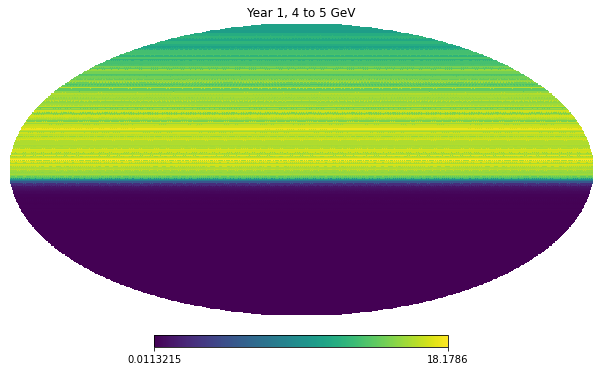

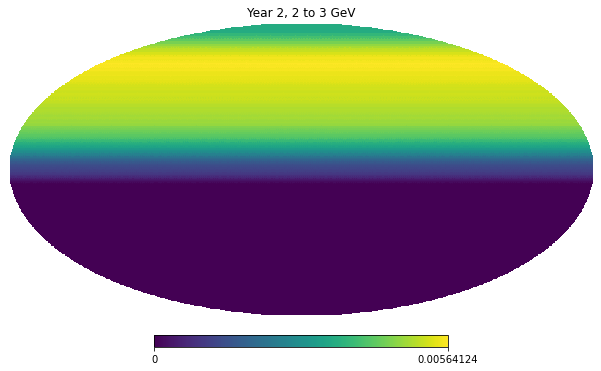

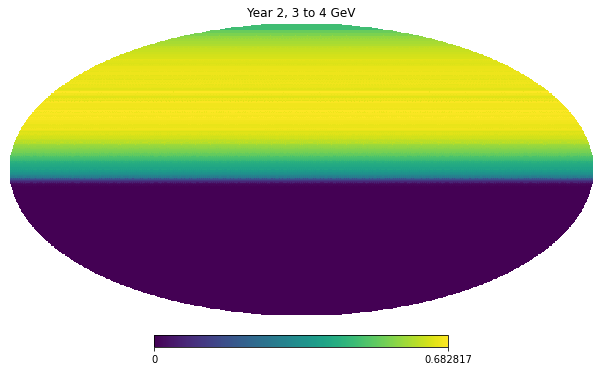

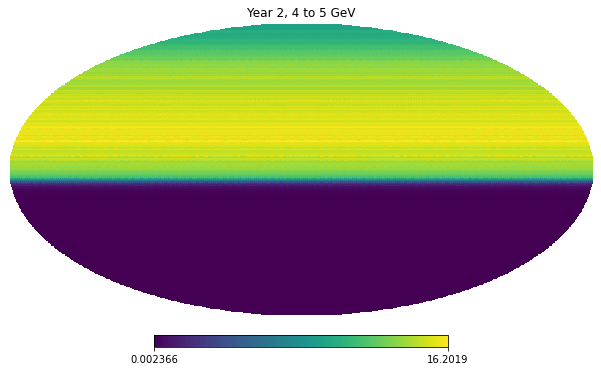

In [11]:
if PlotWeightedAeff == True: 
    #plots weighted effective area on map for each year and energy bin
    for i in range(len(ICAeffList)):
        for j in ICEMapBands:
            WeightedAeffMap = np.ones(hp.nside2npix(NSIDE))
            for k in range(hp.nside2npix(NSIDE)):
                WeightedAeffMap[k] = WeightedEffArea(ICAeffList[i], j[0], j[1],
                                                     (90 + hp.pix2ang(NSIDE, k, lonlat = True)[1]))
            hp.mollview(WeightedAeffMap, title = f'Year {i}, {j[0]} to {j[1]} GeV')

## Plotting Maps

8


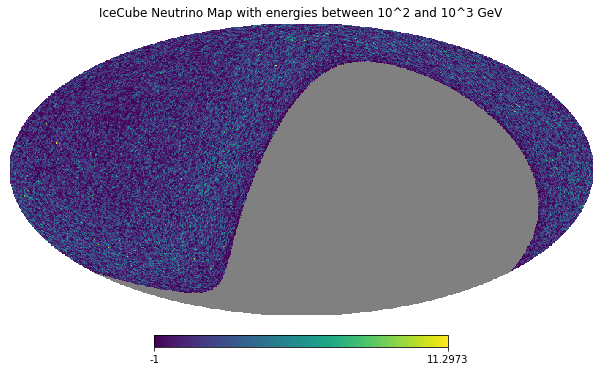

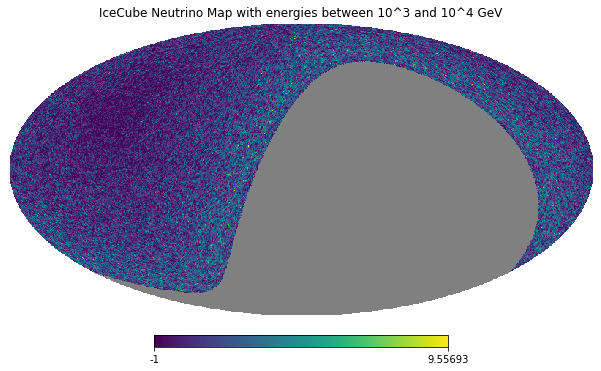

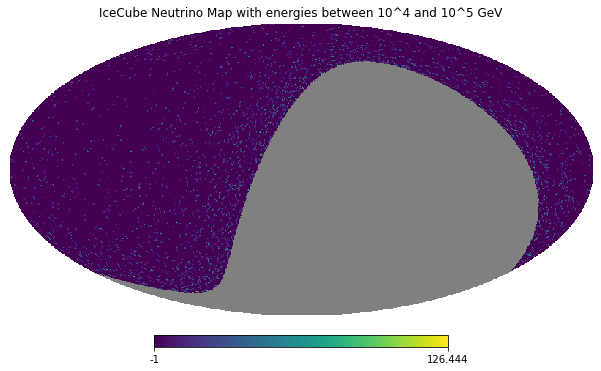

In [12]:
PreMaskMapArrayEqu = [] #array of neutrino events maps before transform to galactic coordinates
PreMaskMapArray = [] #array of neutrino event maps before converting to over/under densities and masking
MapArray = [] #final array of neutrino event maps after above

#defines coordinate transforms
equ2gal = hp.Rotator(coord = 'cg')
gal2equ = hp.Rotator(coord = 'cg', inv = True)

#creates mask based on chosen minimum declination - 1 is unmasked, 0 masked
ICMask = np.ones(hp.nside2npix(NSIDE))
for i in range(len(ICMask)):
    ConvertedDec = np.degrees(np.pi/2 - gal2equ(hp.pix2ang(NSIDE, i))[0]) #finds dec of pixel
    if ConvertedDec < ICDecMin:
        ICMask[i] = 0
        
#number of masked pixels
MaskedPix = len(np.where(ICMask <= 0))

badpixcount = 0

#a map is plotted for each energy band
for ELower, EUpper in ICEMapBands:

    #creates default (i.e. all zeros) array used for healpix map
    PreMaskMapArrayEqu.append(np.zeros(hp.nside2npix(NSIDE)))

    #only keeps energies and declinations within energy band
    ICAllowedE = ICEventFull[np.logical_and(ELower < ICEventFull['log10(E/GeV)'], 
                                            ICEventFull['log10(E/GeV)'] < EUpper)]
    ICEMapData = ICAllowedE[np.where(ICDecMin < ICAllowedE['Dec[deg]'])]

    #gets equatorial coords in radians as numpy arrays
    ICMapDec = np.array(np.pi/2 - np.radians(ICEMapData['Dec[deg]']))
    ICMapRA = np.array(np.radians(ICEMapData['RA[deg]']))

    #converts angular coords to pixel numbers
    ICPixelNumbers = hp.ang2pix(NSIDE, ICMapDec, ICMapRA)

    #loops through events in ICPixelNumbers, increments MapArray values by weighted Aeff value
    for i in range(len(ICPixelNumbers)):
        BuiMapTbl = ICAeffList[ICEMapData[i]['Year']]
        BuiMapE = ICEMapData[i]['log10(E/GeV)']
        BuiMapZen = ICEMapData[i]['Zenith[deg]']
        BuiMapAeff = AeffLookup(BuiMapTbl, BuiMapE, BuiMapZen)
        if BuiMapAeff == 0:
            badpixcount += 1
        if UseAeffWeights == True:
            PreMaskMapArrayEqu[-1][ICPixelNumbers[i]] += 1/BuiMapAeff
        else:
            PreMaskMapArrayEqu[-1][ICPixelNumbers[i]] += 1
        
    #transforms map to galactic coordinates
    PreMaskMapArray.append(equ2gal.rotate_map_pixel(PreMaskMapArrayEqu[-1]))
    
    #total unmasked neutrino events to calculate average for over/under densities
    UnmaskedEvents = np.sum(PreMaskMapArray[-1])
    
    #converts pixel counts to over/underdensities
    UnmaskedPix = hp.nside2npix(NSIDE) - MaskedPix #only calculates average for unmasked pixels
    AvgICMapPix = np.average(UnmaskedEvents/UnmaskedPix)
    MapArray.append((PreMaskMapArray[-1] - AvgICMapPix)/AvgICMapPix)
    
    #sets masked pixels
    MapArray[-1][np.where(ICMask <= 0)] = hp.UNSEEN

    #displays healpix map with masked values
    hp.mollview(hp.ma(MapArray[-1]), 
                title=(f"IceCube Neutrino Map with energies between 10^{ELower} and 10^{EUpper} GeV"))
    #hp.graticule() #adds grid
print(badpixcount)

# Galaxy Maps

## Loading Data

In [13]:
#finds filenames of all galaxy map (and mask) files, sorted alphanumerically
GalMapAllFilenames = sorted(os.listdir(GalMapDir))

#differentiates the galaxy mask file from the galaxy map files
GalMapFilenames = []
for i in GalMapAllFilenames: #only appends files to lists if chosen keywords contained in filenames
    if GalMapKW in i:
        GalMapFilenames.append(i)
    elif GalMaskKW in i: #assumes one mask for all galaxy maps
        GalMaskFilename = i

In [14]:
#reads in galaxy maps
GalMapsOrigRes = []
for i in GalMapFilenames:
    GalMapsOrigRes.append(hp.read_map(GalMapDir + '/' + i))
    
#reads in galaxy mask
GalMaskOrigRes = hp.read_map(GalMapDir + '/' + GalMaskFilename)

## Plotting Maps

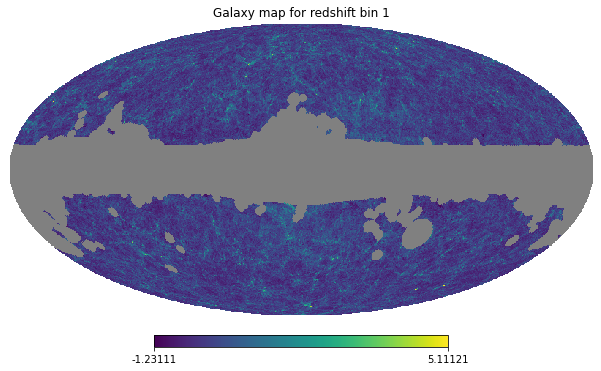

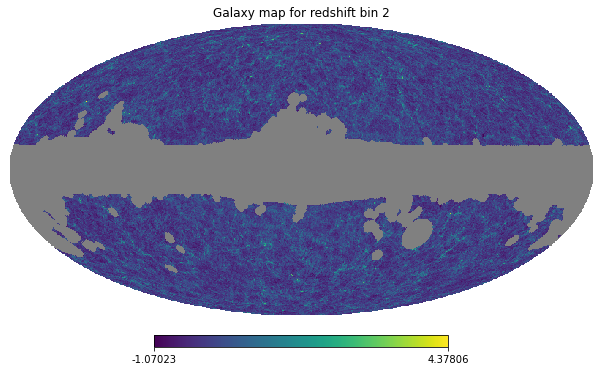

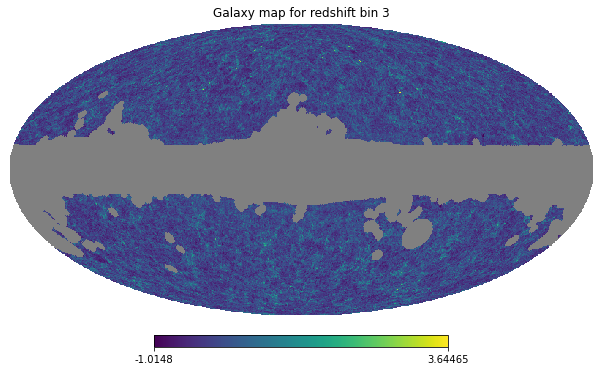

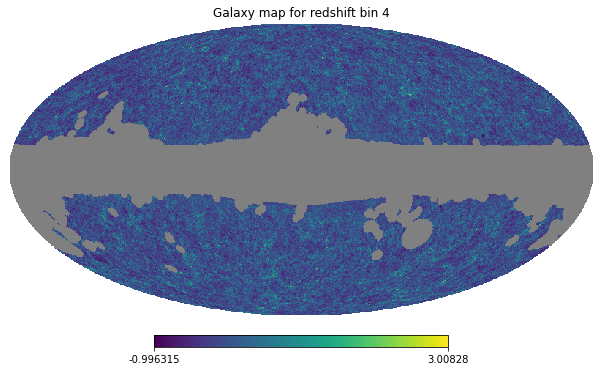

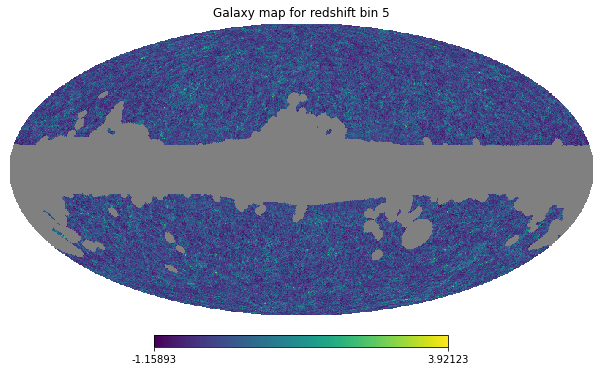

In [15]:
GalMaps = []

#changes galaxy mask NSIDE to match that of IceCube data
GalMask = hp.ud_grade(GalMaskOrigRes, NSIDE)

#fixes mask after NSIDE downgrade - averages of masked/unmasked pixels messes it up
for i in range(len(GalMask)):
    if GalMask[i] < 1:
        GalMask[i] = 0

for i in range(len(GalMapsOrigRes)):
    
    #changes galaxy maps NSIDE to match that of IceCube data
    GalMaps.append(hp.ud_grade(GalMapsOrigRes[i], NSIDE))
    
    #sets masked pixels
    GalMaps[i][np.where(GalMask < 1)] = hp.UNSEEN
    
    #plots maps
    hp.mollview(hp.ma(GalMaps[i]), title = f'Galaxy map for redshift bin {i+1}')

# Angular Power Spectra

## IceCube Auto-correlation

### Equation Approximation

In [16]:
#finds largest l value given in alm coefficients
def alm2lvals(a_lm):
    #a_lm - alm coefficients to find the max l of. Length should always be a triangle number
    
    #finds number of different l values (lmax+1) from formula for triangle numbers
    lvalues = int(np.sqrt(2*len(a_lm)+0.25) - 1/2)
    
    return lvalues

In [17]:
#finds cl using equation from two arrays of a_lm coefficients
def find_cl_eqn(a_lm_1, a_lm_2, lval, fsky):
    #a_lm_1 - first set of a_lm coefficients (to be complex conjugated)
    #a_lm_2 - second set of a_lm coefficients
    #fsky - fraction of sky or which data available
    #lval - l value to find coefficient for
    #lengths of alm coefficient arrays must match
    
    #finds product of alms
    a_lm_prod = np.multiply(np.conj(a_lm_1), a_lm_2)
    
    #ensures l is integer
    lval = int(lval)
    
    #finds triangle number corresponding to l - sum starts on this index of a_lm_prod
    ltri = int((lval+1)*(lval/2))
    
    #sums all elements relating to l. m = 1,2,3... are counted twice to include negative m values
    alm_sum = np.sum(a_lm_prod[ltri:ltri+lval+1]) + np.sum(a_lm_prod[ltri+1:ltri+lval+1])

    #calculates cl coefficient
    c_l = alm_sum/(fsky*(2*lval+1))
    
    return c_l

    

In [18]:
IC_a_lm = []
IC_eqn_c_l = []

#calculates f_sky
ICf_sky = 1 - (MaskedPix/hp.nside2npix(NSIDE))

for i in range(len(MapArray)):
    #finds a_lm (spherical harmonic coefficients) and f_sky (fraction of sky unmasked) for each map
    IC_a_lm.append(hp.map2alm(MapArray[i])) #a_lm coefficients
    
    #finds c_l coefficients for each map
    IC_eqn_c_l.append([])
    for j in range(alm2lvals(IC_a_lm[i])): #loops through all l values
        IC_eqn_c_l[i].append(find_cl_eqn(IC_a_lm[i], IC_a_lm[i], j, ICf_sky))


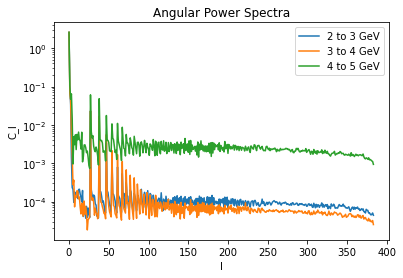

In [19]:
#plots angular power spectra for each energy bin
plt.yscale('log')
for i in range(len(MapArray)):
    plt.plot(np.arange(0,len(IC_eqn_c_l[i])), np.abs(IC_eqn_c_l[i]), 
             label = f'{ICEMapBands[i][0]} to {ICEMapBands[i][1]} GeV')
plt.title('Angular Power Spectra')
plt.xlabel('l')
plt.ylabel('C_l')
plt.legend(bbox_to_anchor = (1, 1))
plt.show()

### Healpy Approximation

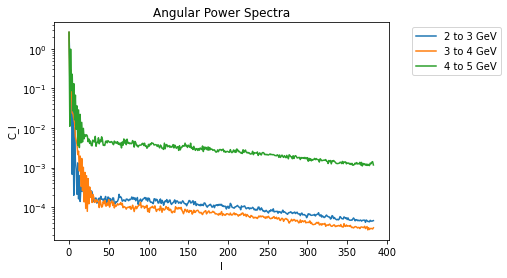

In [20]:
#uses healpy function anafast to approximate c_l values
ICHealpyCl = []
for i in MapArray:
    ICHealpyCl.append(hp.anafast(i))

#plots angular power spectra from these c_l values
plt.yscale('log')
for i in range(len(MapArray)):
    plt.plot(np.arange(0,len(ICHealpyCl[i])), ICHealpyCl[i], 
             label = f'{ICEMapBands[i][0]} to {ICEMapBands[i][1]} GeV')
plt.title('Angular Power Spectra')
plt.xlabel('l')
plt.ylabel('C_l')
plt.legend(bbox_to_anchor = (1.35, 1))
plt.show()

### NaMaster Approximation

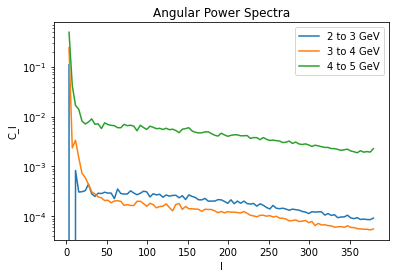

In [21]:
MapArrayField = []
ICNmt_cl = []

#initialise binning scheme with LPerBP l values per bandpower
b = nmt.NmtBin.from_nside_linear(NSIDE, LPerBP)
#finds weighted average l value for each bandpower
l_avg = b.get_effective_ells()

#apodizes (smooths) masks on ApodScale
ICApodMask = nmt.mask_apodization(ICMask, ApodScale, apotype="Smooth")
#hp.mollview(mask, title='Apodized mask')

for i in range(len(MapArray)):

    #initialises maps as fields
    MapArrayField.append(nmt.NmtField(ICApodMask, [MapArray[i]]))
    
    #computes cls
    ICNmt_cl.append(nmt.compute_full_master(MapArrayField[i], MapArrayField[i], b))
    
    #plots angular power spectra for this energy bin
    plt.plot(l_avg, ICNmt_cl[i][0], label = f'{ICEMapBands[i][0]} to {ICEMapBands[i][1]} GeV')

#plot formatting
plt.yscale('log')
plt.title('Angular Power Spectra')
plt.xlabel('l')
plt.ylabel('C_l')
plt.legend(bbox_to_anchor = (1, 1))
plt.show()

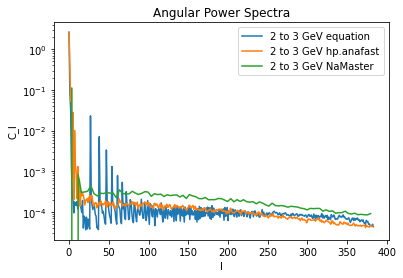

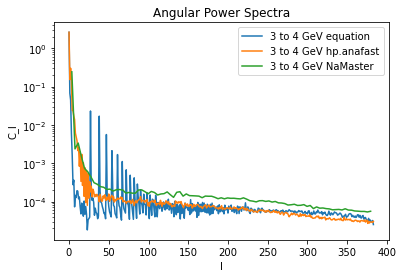

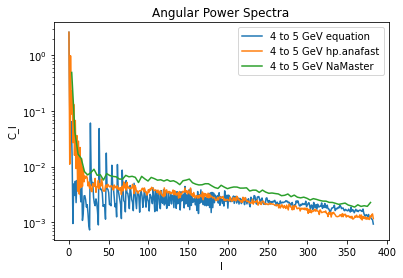

In [22]:
#plots all methods on same figure for each energy bin
for i in range(len(MapArray)):
    plt.plot(np.arange(0,len(IC_eqn_c_l[i])), np.abs(IC_eqn_c_l[i]), 
             label = f'{ICEMapBands[i][0]} to {ICEMapBands[i][1]} GeV equation')
    plt.plot(np.arange(0,len(ICHealpyCl[i])), ICHealpyCl[i],
             label = f'{ICEMapBands[i][0]} to {ICEMapBands[i][1]} GeV hp.anafast')
    plt.plot(l_avg, ICNmt_cl[i][0], label = f'{ICEMapBands[i][0]} to {ICEMapBands[i][1]} GeV NaMaster')
    
    #plot formatting
    plt.yscale('log')
    plt.title('Angular Power Spectra')
    plt.xlabel('l')
    plt.ylabel('C_l')
    plt.legend(loc='upper right')
    plt.show()

### Jackknife Error Functions

In [23]:
def get_regions(mask, n_regions, unassigned=hp.UNSEEN):
    """ Generates `n_regions` regions of roughly equal area
    for a given sky mask `mask`, assuming HEALPix "RING"
    ordering. Returns a HEALPix map where each pixel holds
    the index of the region it is assigned to. Unassigned
    pixels will take the `unassigned` value.
    """
    npix = len(mask)
    nside = hp.npix2nside(npix)
    ipix = np.arange(npix)
    ra, dec = hp.pix2ang(nside, ipix, lonlat=True)
    goodpix = mask > 0
    km = kmeans_sample(np.array([ra[goodpix], dec[goodpix]]).T,
                       n_regions, maxiter=100, tol=1.0e-5,
                       verbose=False)
    map_ids = np.full(npix, unassigned)
    map_ids[ipix[goodpix]] = km.labels
    return map_ids

In [24]:
#generates jackknife masks
def get_jknife_msk(mask, njknife):
    # jackknife regions
    regions = get_regions(mask, njknife, unassigned=hp.UNSEEN)
    # Option 1
    mskjknife = np.array([(regions != i).astype(float)*mask for i in range(njknife)])
    return mskjknife

In [25]:
#calculates jackknife covariance matrix using np.cov
def np_jknife_cov(JKC_ls, njknife):
    
    C_lerrs = (njknife - 1) * np.cov(JKC_ls, rowvar = False, ddof = 0)
    
    return C_lerrs
    
    

In [26]:
#calculates jackknife covariance matrix manually - not used but gives same result
def get_jknife_cov(JKC_ls, njknife):
    #JKC_ls - list of arrays of C_ls to compute errors for
    #njknife - number of jackknife regions
    
    C_lerrs = []
    
    #prefactor for error calculation
    SumPrefactor = (njknife - 1)/njknife
    
    for i in range(len(JKC_ls[0])): #loops over integer ls
        
        C_lerrs.append([])
        
        C_l = [] #holds C_l elements for current sum
        
        for j in range(len(JKC_ls)): #loops over jackknife masks
            C_l.append(JKC_ls[j][i])
        
        #finds mean C_l of jackknife masks for this integer l
        MeanC_l = np.sum(C_l)/len(C_l)
        
        for j in range(len(JKC_ls[0])): #loops over l primes
            
            C_lprime = [] #holds C_l prime elements for current sum
            
            for k in range(len(JKC_ls)): #loops over jackknife masks
                C_lprime.append(JKC_ls[k][j])
        
            #finds mean C_l prime of jackknife masks for this integer l
            MeanC_lprime = np.sum(C_lprime)/len(C_lprime)
            
            #finds sum total in error calculation
            C_lSumTot = np.sum((np.array(C_l) - MeanC_l)*(np.array(C_lprime) - MeanC_lprime))

            #finds error for this integer l
            C_lerrs[i].append(SumPrefactor*C_lSumTot)

    return C_lerrs

In [27]:
def get_JK_cls(mask, maps1, maps2, njknife, cross = False):
    #mask - mask to use
    #maps1 - first set of maps to compute cls for
    #maps2 - second set of maps to compute cls for
    #njknife - number of regions for jackknife resampling
    #cross - whether auto or cross correlation
    
    JKApodMasks = []
    JKFields1 = []
    JKFields2 = []
    JKNmt_cl = []
    
    #finds jackknife masks
    JKMasks = get_jknife_msk(mask, njknife)
    
    #progress bar
    print('Jackknife masks generated.')
    
    for i in range(njknife):
        #apodizes (smooths) masks on ApodScale
        JKApodMasks.append(nmt.mask_apodization(JKMasks[i], ApodScale, apotype="Smooth"))
        
    #calculates c_ls using jackknife resampling
    for i in range(len(maps1)):

        JKFields1.append([])
        JKFields2.append([])
        JKNmt_cl.append([])
        
        if cross == False: #if auto-correlation

            #finds c_ls with each region masked in turn
            for j in range(njknife):

                #initialises maps as fields
                JKFields1[i].append(nmt.NmtField(JKApodMasks[j], [maps1[i]]))
                
                #computes cls
                JKNmt_cl[i].append(nmt.compute_full_master(JKFields1[i][j], JKFields1[i][j], b)[0])
            
            #progress bar
            print(f'Map {i+1} out of {len(maps1)} done.')
                
        else: #if cross-correlation
            for j in range(len(maps2)):
                
                JKFields1[i].append([])
                JKFields2[i].append([])
                JKNmt_cl[i].append([])
                
                #finds c_ls with each region masked in turn
                for k in range(njknife):
                    
                    #initialises maps as fields
                    JKFields1[i][j].append(nmt.NmtField(JKApodMasks[k], [maps1[i]]))
                    JKFields2[i][j].append(nmt.NmtField(JKApodMasks[k], [maps2[j]]))
                    
                    #computes c_ls
                    JKNmt_cl[i][j].append(nmt.compute_full_master(JKFields1[i][j][k], 
                                                                  JKFields2[i][j][k], b)[0])
            
                #progress bar
                print(f'Map {i*len(maps2)+j+1} out of {len(maps1)*len(maps2)} done.')
            
    return JKNmt_cl

### Jackknife Errors

In [28]:
if ImportJKcls == False:
    #gets cls - takes a while
    ICJKNmt_cl = get_JK_cls(ICMask, MapArray, MapArray, JKRegions)
    
    with open(ImportJKclsPath + '/ICJKNmt_cl', 'wb') as fp:   #saves JKcls
        pickle.dump(ICJKNmt_cl, fp)
    
else:
    with open(ImportJKclsPath + '/ICJKNmt_cl', 'rb') as fp:   #imports JKcls
        ICJKNmt_cl = pickle.load(fp)

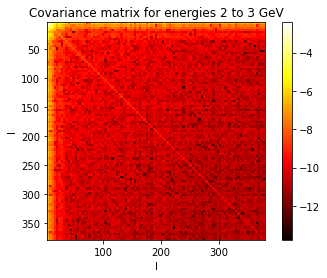

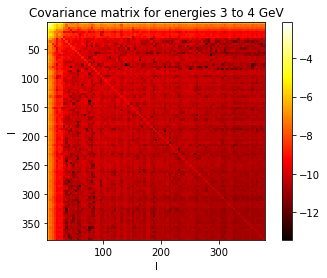

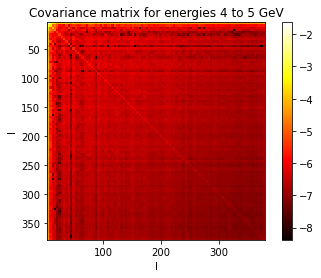

In [29]:
ICJKNmt_cl_cov = []
for i in range(len(MapArray)):
    
    #gets cl covariance matrix for each map
    ICJKNmt_cl_cov.append(np_jknife_cov(ICJKNmt_cl[i], JKRegions))
    
    #plots covariance matrix for each map
    plt.imshow(np.log10(np.abs(ICJKNmt_cl_cov[i])), cmap = 'hot', interpolation = 'nearest', 
              extent = [np.min(l_avg), np.max(l_avg), np.max(l_avg), np.min(l_avg)])
    plt.title(f'Covariance matrix for energies {ICEMapBands[i][0]} to {ICEMapBands[i][1]} GeV')
    plt.xlabel('l')
    plt.ylabel('l')
    plt.colorbar()
    plt.show()

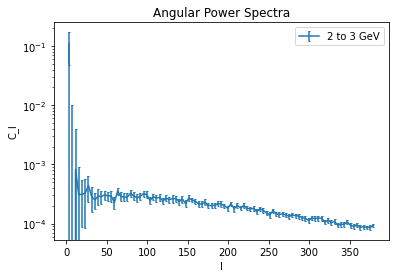

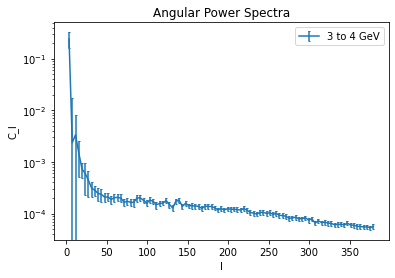

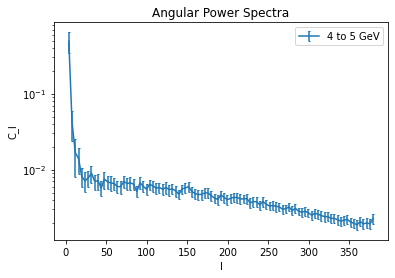

In [30]:
ICJKNmt_cl_err = []
for i in range(len(MapArray)):
    #extracts diagonal elements from the covariance matrix to use as errors
    ICJKNmt_cl_err.append(np.sqrt(np.diag(ICJKNmt_cl_cov[i])))
    
    #plots error bars on angular power spectra
    plt.errorbar(l_avg, ICNmt_cl[i][0], yerr = ICJKNmt_cl_err[i], capsize = 1,
                 label = f'{ICEMapBands[i][0]} to {ICEMapBands[i][1]} GeV')
    
    #plot formatting
    plt.yscale('log')
    plt.title('Angular Power Spectra')
    plt.xlabel('l')
    plt.ylabel('C_l')
    plt.legend(bbox_to_anchor = (1, 1))
    plt.show()

In [31]:
#finds the indices above lmin
lminind = np.where(l_avg >= lmin)

#finds null hypothesis from jackknife errors for each energy bin
ICJKNullHyp = 0
for i in range(len(MapArray)):
    ICJKNullHyp += np.sum(np.array(ICNmt_cl[i][0][lminind])**2/(2*(ICJKNmt_cl_err[i][lminind])**2))
    
print(f'Null hypothesis for IC auto-correlation: {ICJKNullHyp}')

Null hypothesis for IC auto-correlation: 9555.406688141473


## Galaxy Auto-correlation

### NaMaster Approximation

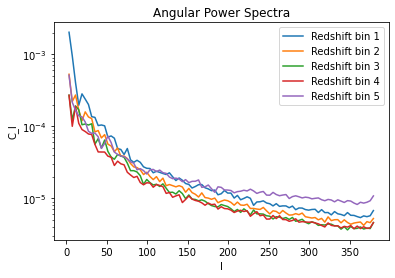

In [32]:
GalMapsField = []
GalNmt_cl = []

#apodizes (smooths) masks on ApodScale
GalApodMask = nmt.mask_apodization(GalMask, ApodScale, apotype="Smooth")
#hp.mollview(mask, title='Apodized mask')

for i in range(len(GalMaps)):

    #initialises maps as fields
    GalMapsField.append(nmt.NmtField(GalApodMask, [GalMaps[i]]))
    
    #computes cls
    GalNmt_cl.append(nmt.compute_full_master(GalMapsField[i], GalMapsField[i], b))
    
    #plots angular power spectra for this redshift bin
    plt.plot(l_avg, GalNmt_cl[i][0], label = f'Redshift bin {i+1}')

#plot formatting
plt.yscale('log')
plt.title('Angular Power Spectra')
plt.xlabel('l')
plt.ylabel('C_l')
plt.legend(bbox_to_anchor = (1, 1))
plt.show()

### Jackknife Errors

In [33]:
if ImportJKcls == False:
    #gets cls - takes a while
    GalJKNmt_cl = get_JK_cls(GalMask, GalMaps, GalMaps, JKRegions)
    
    with open(ImportJKclsPath + '/GalJKNmt_cl', 'wb') as fp:   #saves JKcls
        pickle.dump(GalJKNmt_cl, fp)
    
else:
    with open(ImportJKclsPath + '/GalJKNmt_cl', 'rb') as fp:   #imports JKcls
        GalJKNmt_cl = pickle.load(fp)

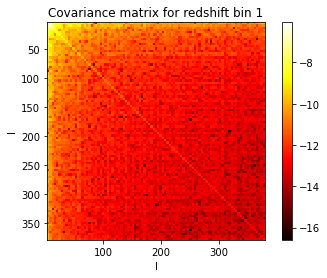

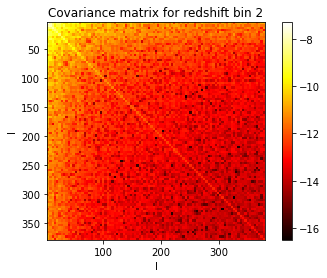

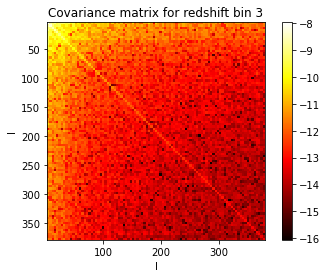

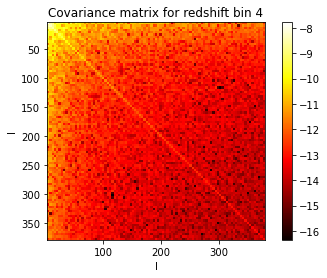

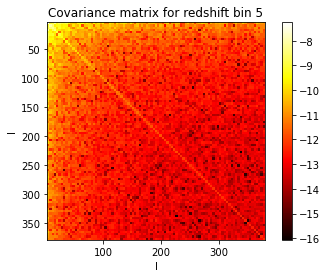

In [34]:
GalJKNmt_cl_cov = []
for i in range(len(GalMaps)):
    
    #gets cl covariance matrix for each map
    GalJKNmt_cl_cov.append(np_jknife_cov(GalJKNmt_cl[i], JKRegions))
    
    #plots covariance matrix for each map
    plt.imshow(np.log10(np.abs(GalJKNmt_cl_cov[i])), cmap = 'hot', interpolation = 'nearest', 
              extent = [np.min(l_avg), np.max(l_avg), np.max(l_avg), np.min(l_avg)])
    plt.title(f'Covariance matrix for redshift bin {i+1}')
    plt.xlabel('l')
    plt.ylabel('l')
    plt.colorbar()
    plt.show()

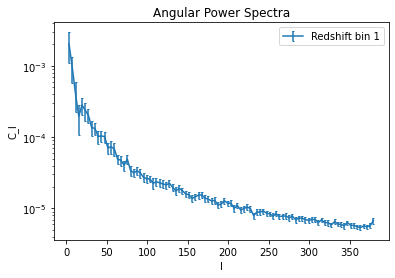

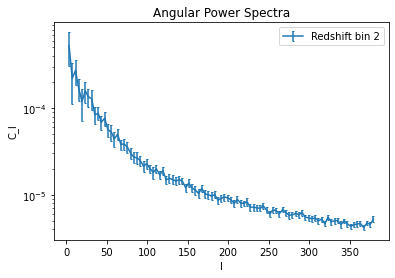

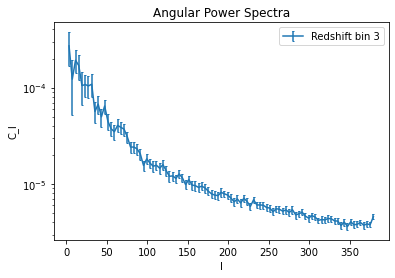

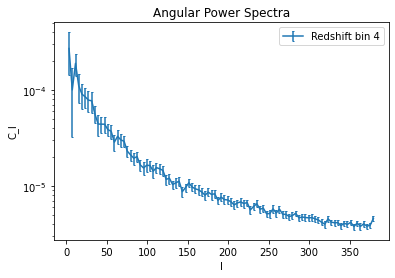

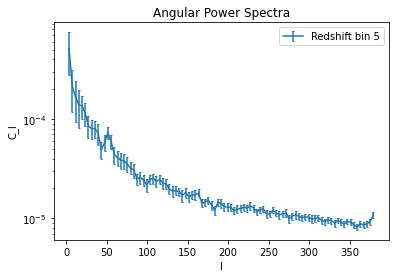

In [35]:
GalJKNmt_cl_err = []
for i in range(len(GalMaps)):
    #extracts diagonal elements from the covariance matrix to use as errors
    GalJKNmt_cl_err.append(np.sqrt(np.diag(GalJKNmt_cl_cov[i])))
    
    #plots error bars on angular power spectra
    plt.errorbar(l_avg, GalNmt_cl[i][0], yerr = GalJKNmt_cl_err[i], capsize = 1,
                 label = f'Redshift bin {i+1}')
    
    #plot formatting
    plt.yscale('log')
    plt.title('Angular Power Spectra')
    plt.xlabel('l')
    plt.ylabel('C_l')
    plt.legend(bbox_to_anchor = (1, 1))
    plt.show()

In [36]:
#finds null hypothesis from jackknife errors for each energy bin
GalJKNullHyp = []
for i in range(len(GalMaps)):
    GalJKNullHyp.append(np.sum(np.array(GalNmt_cl[i][0][lminind])**2/(2*(GalJKNmt_cl_err[i][lminind])**2)))
    
    print(f'Null hypothesis for redshift bin {i+1}: {GalJKNullHyp[i]}')

Null hypothesis for redshift bin 1: 4721.313955095384
Null hypothesis for redshift bin 2: 5235.582162618334
Null hypothesis for redshift bin 3: 5229.354429735189
Null hypothesis for redshift bin 4: 5353.194495917637
Null hypothesis for redshift bin 5: 5315.042760186309


## Cross-correlation

### NaMaster Approximation

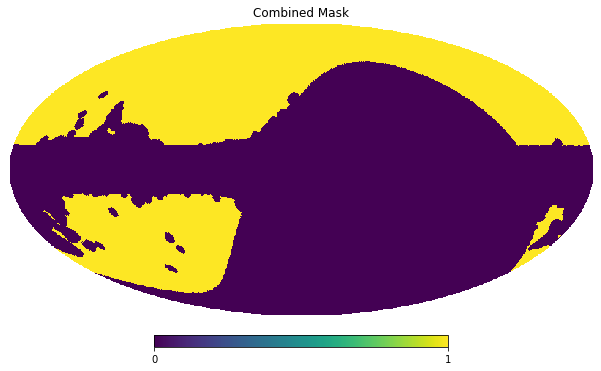

In [37]:
#creates combined masks of IceCube data and galaxy maps
CrossMask = np.multiply(ICMask, GalMask)
    
#shows combined mask
hp.mollview(CrossMask, title = 'Combined Mask')

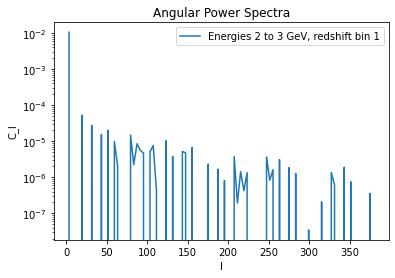

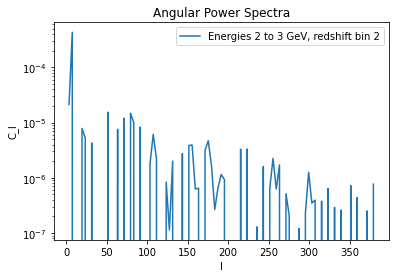

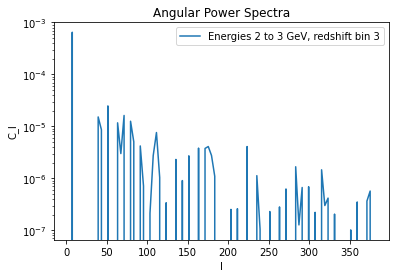

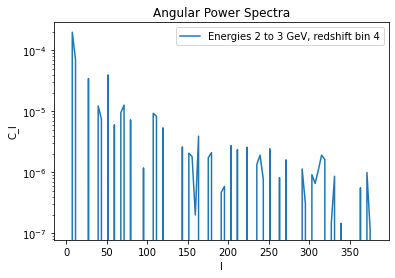

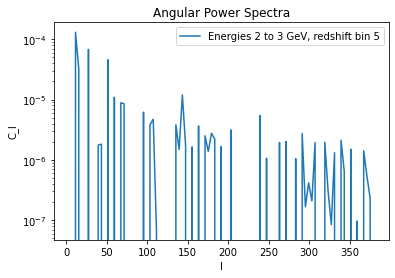

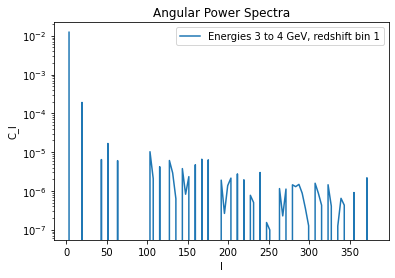

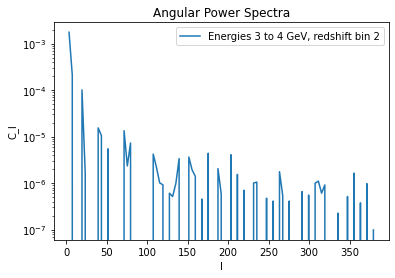

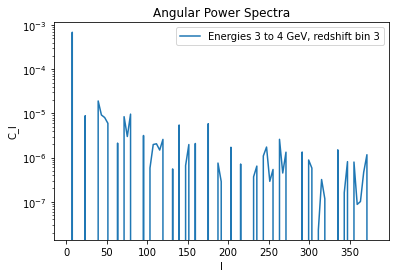

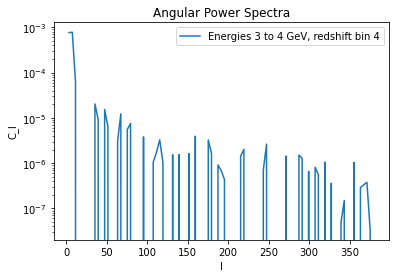

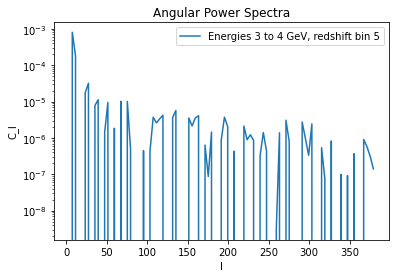

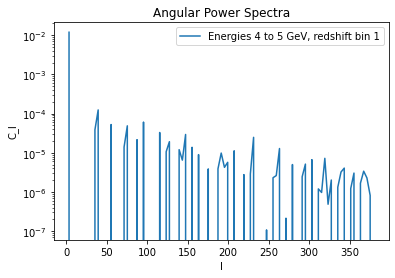

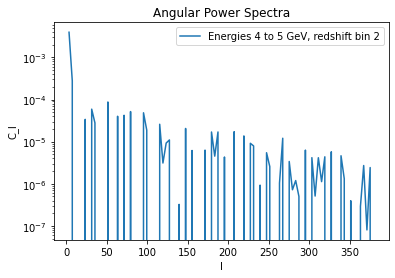

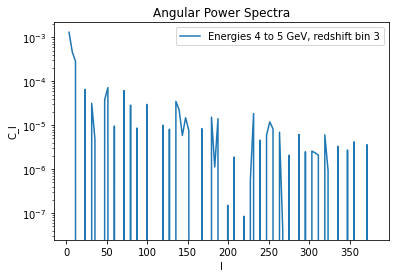

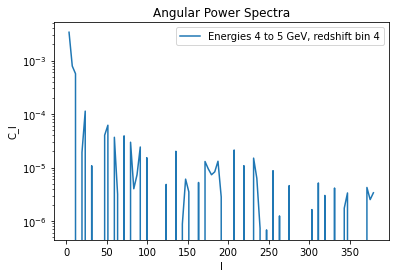

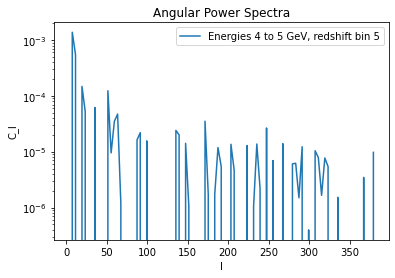

In [38]:
CrossNmt_cl = []
CrossMapArrayField = []
CrossGalMapsField =[]

#apodizes (smooths) masks on ApodScale
CrossApodMask = nmt.mask_apodization(CrossMask, ApodScale, apotype="Smooth")
#hp.mollview(mask, title='Apodized mask')

for i in range(len(MapArray)): #loops over neutrino energy bins
    
    CrossNmt_cl.append([])
    
    #initialises IceCube fields
    CrossMapArrayField.append(nmt.NmtField(CrossApodMask, [MapArray[i]]))
    
    for j in range(len(GalMaps)): #loops over galaxy redshift bins
        
        #initialises galaxy fields
        CrossGalMapsField.append(nmt.NmtField(CrossApodMask, [GalMaps[j]]))
    
        #computes cross cls
        CrossNmt_cl[i].append(nmt.compute_full_master(CrossMapArrayField[i], CrossGalMapsField[j], b))
        
        #plots angular power spectra for this redshift bin
        plt.plot(l_avg, CrossNmt_cl[i][j][0], 
                 label = f'Energies {ICEMapBands[i][0]} to {ICEMapBands[i][1]} GeV, redshift bin {j+1}')

        #plot formatting
        plt.yscale('log')
        plt.title('Angular Power Spectra')
        plt.xlabel('l')
        plt.ylabel('C_l')
        plt.legend(bbox_to_anchor = (1, 1))
        plt.show()


### Jackknife Errors

In [39]:
if ImportJKcls == False:
    #gets cls - takes a long while
    CrossJKNmt_cl = get_JK_cls(CrossMask, MapArray, GalMaps, JKRegions, cross = True)
    
    with open(ImportJKclsPath + '/CrossJKNmt_cl', 'wb') as fp:   #saves JKcls
        pickle.dump(CrossJKNmt_cl, fp)
    
else:
    with open(ImportJKclsPath + '/CrossJKNmt_cl', 'rb') as fp:   #imports JKcls
        CrossJKNmt_cl = pickle.load(fp)

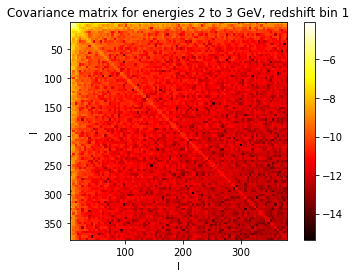

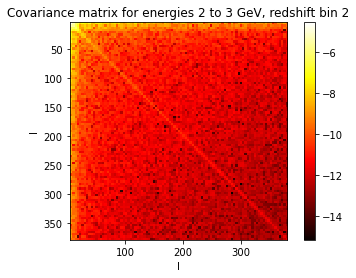

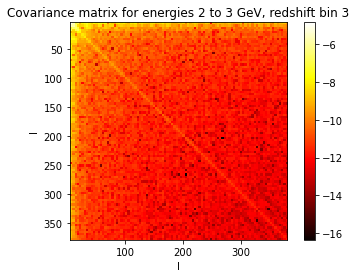

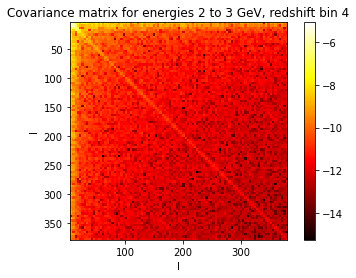

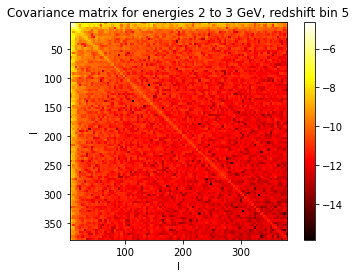

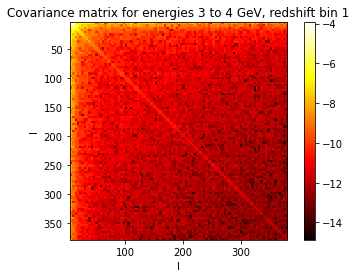

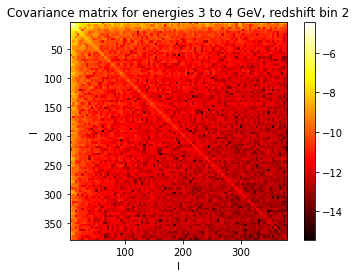

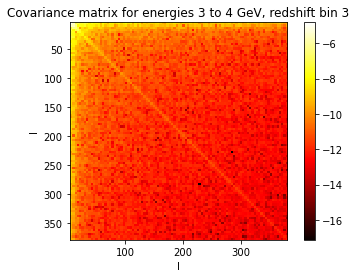

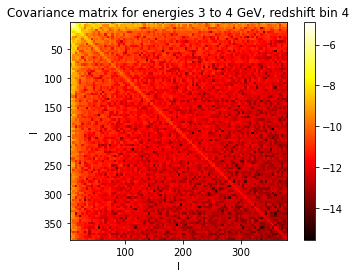

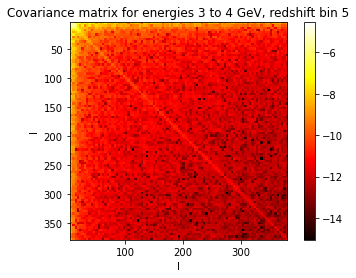

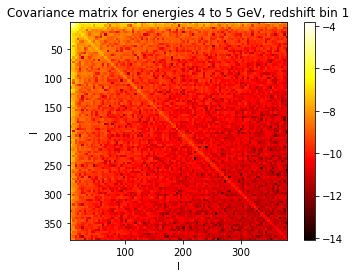

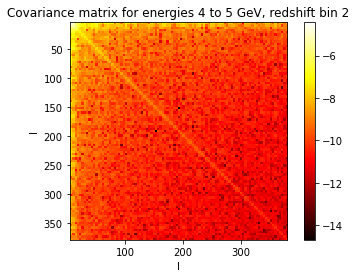

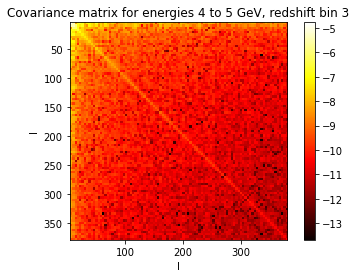

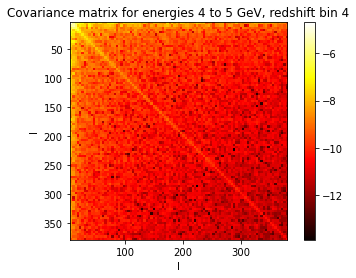

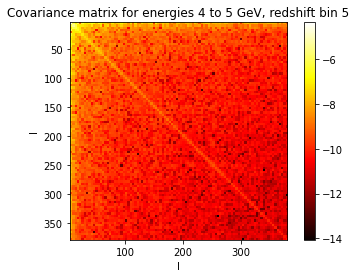

In [40]:
CrossJKNmt_cl_cov = []
for i in range(len(MapArray)): #loops over energy bins
    
    CrossJKNmt_cl_cov.append([])
    
    for j in range(len(GalMaps)): #loops over redshift bins
    
        #gets cl covariance matrix for each map
        CrossJKNmt_cl_cov[i].append(np_jknife_cov(CrossJKNmt_cl[i][j], JKRegions))

        #plots covariance matrix for each map
        plt.imshow(np.log10(np.abs(CrossJKNmt_cl_cov[i][j])), cmap = 'hot', interpolation = 'nearest', 
                  extent = [np.min(l_avg), np.max(l_avg), np.max(l_avg), np.min(l_avg)])
        plt.title(f'Covariance matrix for energies {ICEMapBands[i][0]} to {ICEMapBands[i][1]} GeV,' +
                  f' redshift bin {j+1}')
        plt.xlabel('l')
        plt.ylabel('l')
        plt.colorbar()
        plt.show()

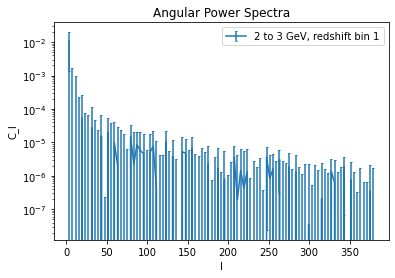

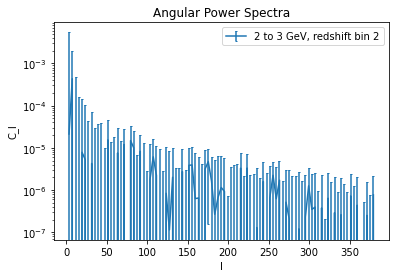

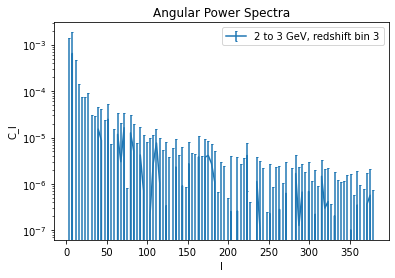

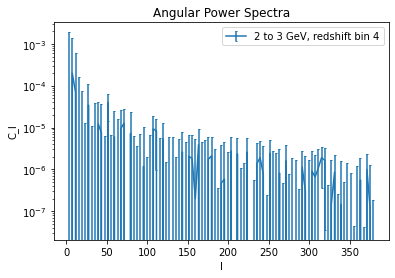

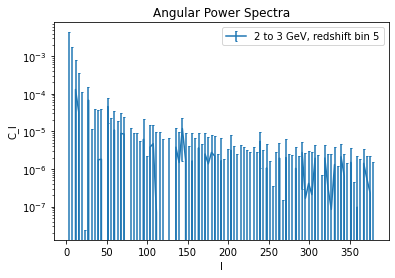

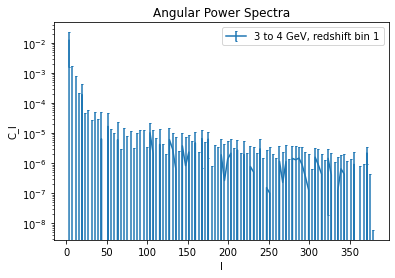

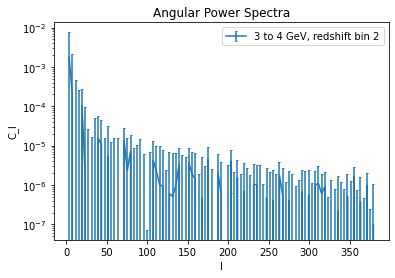

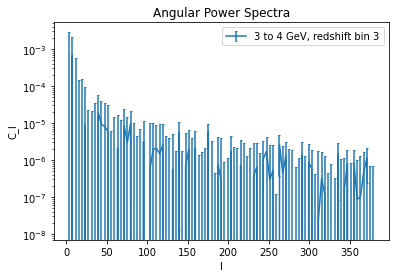

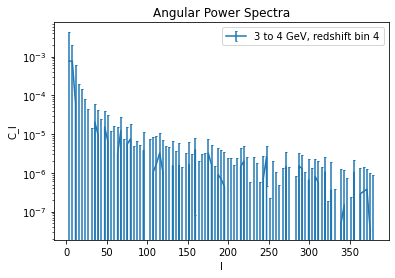

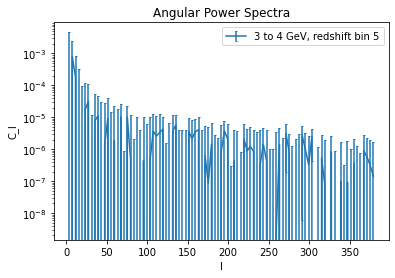

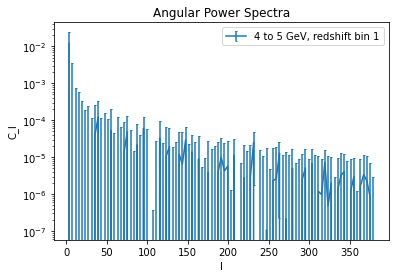

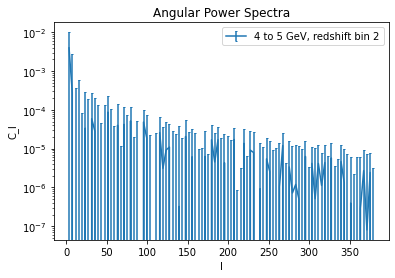

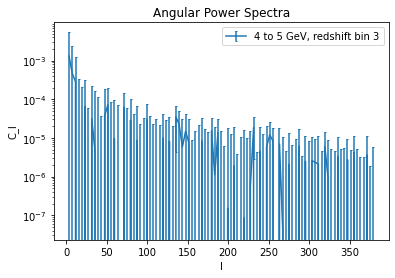

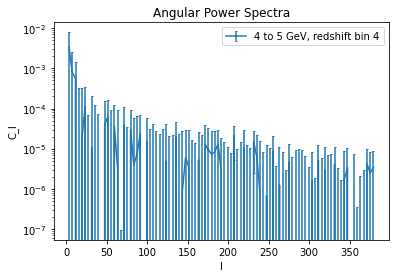

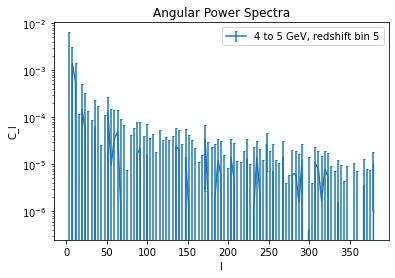

In [41]:
CrossJKNmt_cl_err = []

for i in range(len(MapArray)):
    
    CrossJKNmt_cl_err.append([])
    
    for j in range(len(GalMaps)):
        #extracts diagonal elements from the covariance matrix to use as errors
        CrossJKNmt_cl_err[i].append(np.sqrt(np.diag(CrossJKNmt_cl_cov[i][j])))

        #plots error bars on angular power spectra
        plt.errorbar(l_avg, CrossNmt_cl[i][j][0], yerr = CrossJKNmt_cl_err[i][j], capsize = 1,
                     label = f'{ICEMapBands[i][0]} to {ICEMapBands[i][1]} GeV, redshift bin {j+1}')

        #plot formatting
        plt.yscale('log')
        plt.title('Angular Power Spectra')
        plt.xlabel('l')
        plt.ylabel('C_l')
        plt.legend(bbox_to_anchor = (1, 1))
        plt.show()

In [42]:
#finds null hypothesis from jackknife errors for each energy/redshift bin combination

CrossJKNullHyp = []

for i in range(len(GalMaps)): #each redshift bin
    
    CrossJKNullHyp.append(0)
    
    for j in range(len(MapArray)): #each energy bin
        
        CrossJKNullHyp[i] += np.sum(np.array(CrossNmt_cl[j][i][0][lminind])**2/(2*(CrossJKNmt_cl_err[j][i][lminind])**2))

    print(f'Null hypothesis for redshift bin {i+1}: {CrossJKNullHyp[i]}')

Null hypothesis for redshift bin 1: 35.35272450732407
Null hypothesis for redshift bin 2: 29.67093837402631
Null hypothesis for redshift bin 3: 31.692297415378185
Null hypothesis for redshift bin 4: 36.812383381852854
Null hypothesis for redshift bin 5: 33.35900341116526
